## Tagging Labeling Using Word2Vec

- tokenize/POS tagging
    - `norm`, `stem`을 모두 `True`로 설정
    - 각 label당 token 수를 줄이기 위해
    - But, '재밌다'와 '재밌냐' 등, 어미의 변화에 따른 정보 손실
    

- Corpus Construction for labeling

In [38]:
from konlpy.tag import Twitter; twitter = Twitter()
import nltk
from gensim.models import word2vec
from pprint import pprint
import matplotlib.pyplot as plt

from file_io import *
from words_preprocessing import *

In [2]:
%%time

train_data = read_data('../reviews/all_contents_03.txt')
train_docs = [tokenize(row[0]) for row in train_data]

CPU times: user 3min 56s, sys: 1.2 s, total: 3min 57s
Wall time: 3min 44s


In [3]:
pprint(train_docs[100])

['그게/Noun',
 '무슨/Noun',
 '의미/Noun',
 '가/Josa',
 '있다/Adjective',
 '?/Punctuation',
 '삶/Noun',
 '의/Josa',
 '의미/Noun',
 '를/Josa',
 '다시/Noun',
 '찾다/Verb',
 '날/Noun',
 '좋다/Adjective',
 '영화/Noun',
 '이다/Verb',
 './Punctuation']


In [4]:
import nltk

tokens = [t for d in train_docs for t in d]
text = nltk.Text(tokens, name="TOKENS")
print(text)

<Text: TOKENS>


In [5]:
print(len(text.tokens))
print(len(set(text.tokens)))
pprint(text.vocab().most_common(10))

3931769
63779
[('./Punctuation', 115283),
 ('하다/Verb', 93744),
 ('영화/Noun', 90605),
 ('이/Josa', 71434),
 ('보다/Verb', 65114),
 ('의/Josa', 51345),
 ('에/Josa', 49016),
 ('../Punctuation', 47244),
 ('가/Josa', 46659),
 ('을/Josa', 42707)]


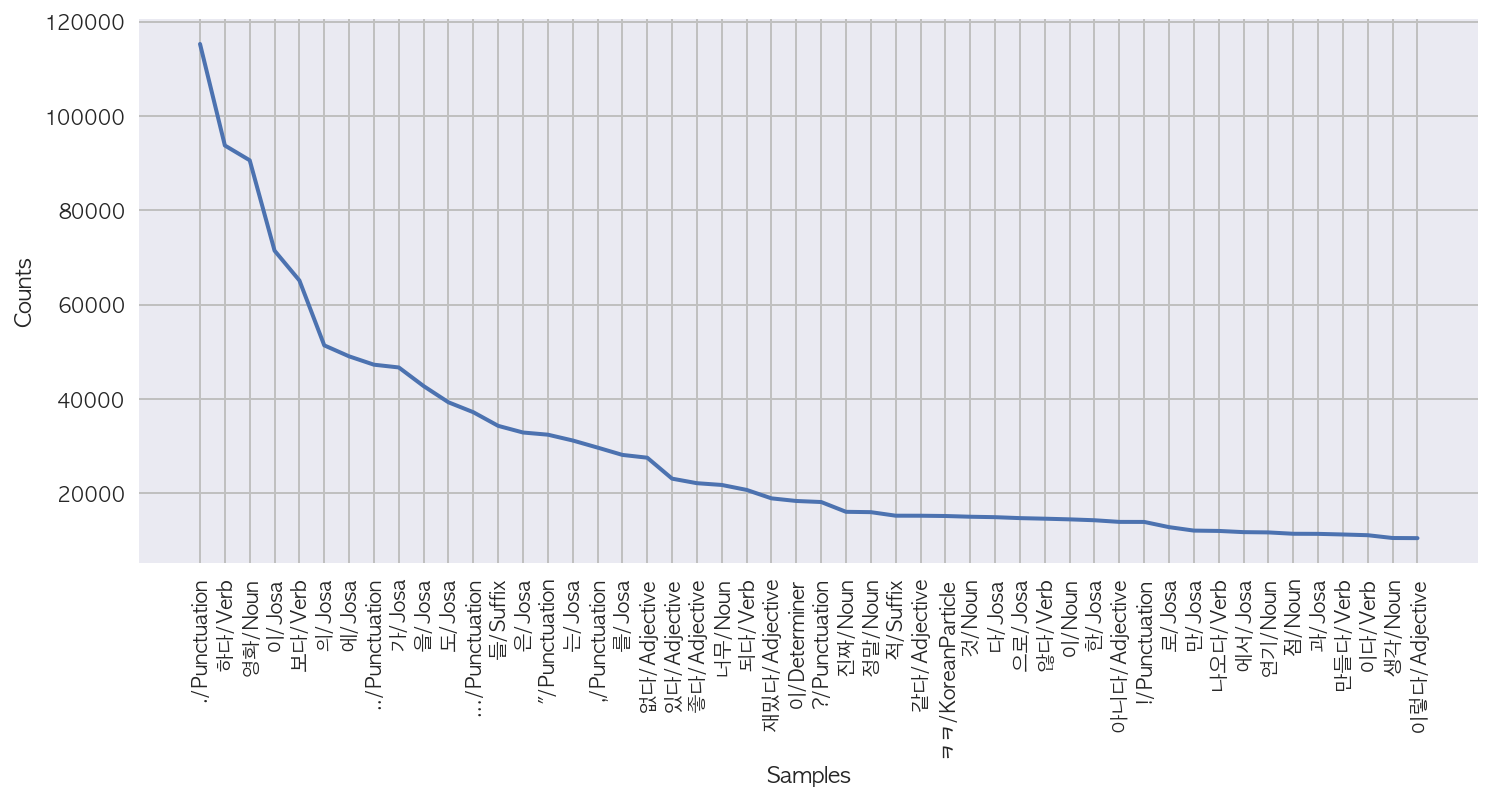

In [6]:
plt.figure(figsize=(12,5))
text.plot(50)

- 재미 있다/없다 등 직접적인 감상평 토큰이 가장 많이 등장
- 그 외 등장 토큰은 영화, 보다, 연기 등 역시 영화 관련 토큰

In [7]:
%%time
from gensim.models import word2vec
model = word2vec.Word2Vec(train_docs, size=300, workers=4, min_count=10, iter=100)

CPU times: user 16min 37s, sys: 3.5 s, total: 16min 41s
Wall time: 4min 34s


In [8]:
emotion_pair = {
    'joy': '기쁘다', 
    'anger': '화나다', 
    'disgust': '역겹다',
    'sadness': '슬프다',
    'fear': '무섭다',
}

emotion_ko_list = list(emotion_pair.values())
emotion_ko_dic = {
    '기쁘다': 0, 
    '화나다': 1, 
    '역겹다': 2,
    '슬프다': 3,
    '무섭다': 4,
}

emotion_ko_list = [tokenize(row)[0] for row in emotion_ko_list]
emotion_ko_list

['기쁘다/Adjective',
 '화나다/Verb',
 '역겹다/Adjective',
 '슬프다/Adjective',
 '무섭다/Adjective']

In [9]:
model.wv.most_similar(emotion_ko_list[0], topn=15)

[('행복하다/Adjective', 0.4087655544281006),
 ('고맙다/Adjective', 0.37825149297714233),
 ('감사/Noun', 0.31997227668762207),
 ('일찍/Noun', 0.2784136235713959),
 ('희망이/Noun', 0.26040494441986084),
 ('뿌듯하다/Adjective', 0.25930964946746826),
 ('반갑다/Adjective', 0.2543483376502991),
 ('기회/Noun', 0.2505105137825012),
 ('기쁨/Noun', 0.24919046461582184),
 ('사랑스럽다/Adjective', 0.24757051467895508),
 ('미소/Noun', 0.24485355615615845),
 ('우연히/Adverb', 0.24467192590236664),
 ('즐겁다/Adjective', 0.24393346905708313),
 ('멋지다/Adjective', 0.24367985129356384),
 ('늦다/Verb', 0.23918263614177704)]

In [10]:
emotion_corpus = pd.read_csv('../emotion_corpus_labeled.txt', encoding='utf-8', sep=',')

joy_list = emotion_corpus[emotion_corpus['emotion']==0].values.tolist()
anger_list = emotion_corpus[emotion_corpus['emotion']==1].values.tolist()
disgust_list = emotion_corpus[emotion_corpus['emotion']==2].values.tolist()
sadness_list = emotion_corpus[emotion_corpus['emotion']==3].values.tolist()
fear_list = emotion_corpus[emotion_corpus['emotion']==4].values.tolist()

joy_list = [row[0] for row in joy_list]
anger_list = [row[0] for row in anger_list]
disgust_list = [row[0] for row in disgust_list]
sadness_list = [row[0] for row in sadness_list]
fear_list = [row[0] for row in fear_list]

len(joy_list), len(anger_list), len(disgust_list), len(sadness_list), len(fear_list)

(174, 196, 179, 154, 106)

In [11]:
pprint(joy_list[:3])

['기쁘다/Adjective', '감동/Noun', '감사/Noun']


In [12]:
train_docs_labeled = get_labels(train_docs, joy_list, anger_list, 
                                disgust_list, sadness_list, fear_list)
all_labeled = [row[1] for row in train_docs_labeled]

In [16]:
from collections import Counter
label_count = Counter(all_labeled)
sum_ = sum(label_count.values())

print("Number of Data: ", sum_)
pprint(label_count)
print()
for label in label_count.keys():
    print(label ,": {}%".format(round(label_count[label] / sum_, 2)))

Number of Data:  252847
Counter({'기쁘다': 80251,
         '중립': 77900,
         '화나다': 41013,
         '슬프다': 20687,
         '역겹다': 20376,
         '무섭다': 12620})

무섭다 : 0.05%
중립 : 0.31%
역겹다 : 0.08%
슬프다 : 0.08%
기쁘다 : 0.32%
화나다 : 0.16%


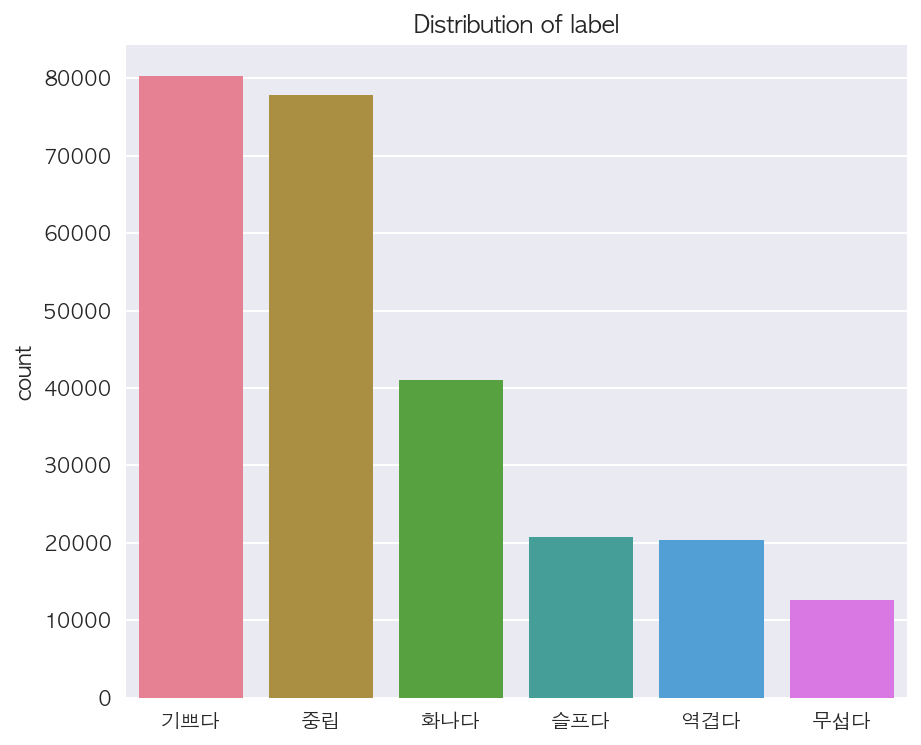

In [28]:
df = pd.DataFrame(list(label_count.values()), 
                  index=list(label_count.keys()), 
                  columns=['count'])
df.sort_values(by=['count'], ascending=False, inplace=True)

plt.figure(figsize=(7, 6))
plt.title("Distribution of label")
sns.barplot(x=df.index, y=df['count'], data=df, palette='husl');

### 중립으로 판별된 리뷰
1. 다섯 가지 감정으로 분류하기 어려운 리뷰
> *가이 리치의 영화, 1998년 록 스탁 앤 투 스모킹 배럴즈를 좋아하는 저는, 글쎄요, 극적 설정과 줄거리에 회의가 들어요.*
2. 리뷰만으로는 긍정/부정을 알기 어려운 리뷰
> *보면아십니다*
3. 감정을 나타내는 어휘가 없는 리뷰
> *디지털로 보는 필름과 소셜리즘*

**solution: 일일이 확인하며 레이블 태깅**

In [31]:
emotion_label = [row[1] for row in train_docs_labeled]
train_data_labeled = [([train_data[i][0]], emotion_label[i]) for i in range(len(emotion_label))]

In [34]:
train_data_labeled[2]

(['"난무하는 욕설이나 더러운 말들, OO란 단어의 반복까진 참았다. 남녀가 첫만남부터 잠자리 함께 하고, 남자가 이것을 자꾸 되돌리는 장면에선 구역질이 낫다. 쓰레기 같은 영화."'],
 '역겹다')

In [35]:
train_data_labeled_joy = [row[0] for row in train_data_labeled if row[1] == '기쁘다']
train_data_labeled_anger = [row[0] for row in train_data_labeled if row[1] == '화나다']
train_data_labeled_disgust = [row[0] for row in train_data_labeled if row[1] == '역겹다']
train_data_labeled_sadness = [row[0] for row in train_data_labeled if row[1] == '슬프다']
train_data_labeled_fear = [row[0] for row in train_data_labeled if row[1] == '무섭다']

In [42]:
train_joy = read_data('../train_data_labeled_joy.txt')
train_anger = read_data('../train_data_labeled_anger.txt')
train_disgust = read_data('../train_data_labeled_disgust.txt')
train_sadness = read_data('../train_data_labeled_sadness.txt')
train_fear = read_data('../train_data_labeled_fear.txt')

print("필터링 이후 데이터 개수:")
print(len(train_joy), len(train_anger), 
      len(train_disgust), len(train_sadness), len(train_fear))

필터링 이후 데이터 개수:
73614 40501 20390 20701 10604


In [43]:
print(len(train_data_labeled_joy) - len(train_joy))
print(len(train_data_labeled_anger) - len(train_anger))
print(len(train_data_labeled_disgust) - len(train_disgust))
print(len(train_data_labeled_sadness) - len(train_sadness))
print(len(train_data_labeled_fear) - len(train_fear))

6637
512
-14
-14
2016


- 데이터 필터링 (레이블과 맞지 않는 데이터 제거)
- 필터링 이후 데이터 개수:
    - 기쁘다: 77601 (-6637)
    - 화나다: 40201 (-512)
    - 역겹다: 20311 (+14)
    - 슬프다: 20691 (+14)
    - 무섭다: 10615 (-2016)
    

- `tokenizer`의 한계로 부정문, 조사에 따른 변화를 (교착어의 특성을) 제대로 잡아내지 못함
- 특히 `norm`과 `stem` 모두 `True`로 설정:
    - `tokenize('무서워')` --> '무섭다/Adjective'
    - `tokenize('무섭냐')` --> '무섭다/Adjective'

In [46]:
train_lst = [train_joy, train_anger, train_disgust, train_sadness, train_fear]

train = []
for data in train_lst:
    train += data

print(len(train))

165810
